# Introduction

The analysis contains several sections:
- Data Preperation
- Descriptive statistics and graphs regarding the whole data
- Modeling installation of HaMagen using logistic regression 
- Analyzing demographics of installing Hamagen
- Modeling approval with cellular contact tracing using OLS
- Modeling recommending HaMagen using OLS
- Modeling uninstallation of Hamagen using logistic regression

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import researchpy as rp
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
from statsmodels.formula.api import ols
import seaborn as sns
import scipy.stats as stats




# Data Preperation

In [2]:
sur = pd.read_csv('/Users/erantoch/Google Drive/Research/Pbd for Covid19/Survey/covid_survey.csv', index_col='Response ID')
sur.head()

,Time Started,Date Submitted,Status,age,corona_threat_population,corona_threat_me,corona_worry_me,corona_worry_others,trust_leaders,follow_instructions,...,language,hamagen_install_numbers,installed,gender_ord,socio_economy_level,education_level,religion_level,age_group,hamagen_can_collect,tech
Response ID,,,,,,,,,,,,,,,,,,,,,
379,05/05/2020 16:23,05/05/2020 16:26,Complete,21.0,3,2,4,4,3,5,...,hebrew,0,0,1,1,2,1,2,3,4.8
61,04/05/2020 19:23,04/05/2020 19:29,Complete,34.0,4,3,5,5,4,5,...,arabic,0,0,1,0,2,2,3,4,1.4
280,05/05/2020 15:22,05/05/2020 15:24,Complete,21.0,2,3,4,2,3,3,...,arabic,1,1,1,1,4,3,2,3,3.0
288,05/05/2020 15:24,05/05/2020 15:33,Complete,65.0,2,3,1,1,4,5,...,hebrew,0,0,0,3,2,1,6,4,2.0
96,04/05/2020 23:27,04/05/2020 23:30,Complete,37.0,2,2,3,4,2,3,...,arabic,0,0,1,3,4,2,3,5,2.8


## Creating Factors

Notice that factor eveluation is done somewhere below

In [3]:


sur['hamagen_privacy'] = (sur.hamagen_privacy_concern + sur.hamagen_can_collect_sensitive) / 2
sur['cellular_utility'] = (sur.cellular_help_prevent + sur.cellular_reduce_my_risk) / 2
sur['cellular_privacy'] = (sur.cellular_privacy_concern + sur.cellular_can_collect) / 2
sur['hamagen_utility'] = (sur.hamagen_help_no_infect + sur.hamagen_reduce_my_risk) / 2
sur['cellular_attitude'] = (sur.cellular_help_prevent + sur.cellular_reduce_my_risk + sur.cellular_trust_delete) / 3 
sur['hamagen_attitude'] = (sur.hamagen_recommend + sur.hamagen_public_areas) / 2
sur['covid_concern'] = (sur.corona_threat_population + sur.corona_threat_me + sur.corona_worry_me) / 3


sur['tech'] = (sur['know_pdf'] + sur['know_wiki'] + sur['know_cache'] + sur['know_phishing'] + sur['know_spyware'])/5




In [4]:
hamagen_cols=['hamagen_recommend', 'hamagen_public_areas', 'hamagen_help_no_infect', 'hamagen_reduce_my_risk', 'hamagen_privacy_concern', 
      'hamagen_can_collect_sensitive'] 

cellular_cols=['cellular_help_prevent', 'cellular_reduce_my_risk', 'cellular_trust_delete', 'cellular_privacy_concern', 'cellular_can_collect', 
      'cellular_accept_leave_phone_home'] 

covid_cols=['corona_threat_population', 'corona_threat_me', 'corona_worry_others', 'corona_worry_me', 'trust_leaders', 
      'follow_instructions', 'corona_financial_hurt'] 

binary_cols=['work_in_healthcare', 'special_risk', 'corona_family_risk', 'corona_know_positive', 'corona_positive', 
      'was_in_quarentine'] 

sur[binary_cols].describe().transpose()

,count,unique,top,freq
work_in_healthcare,519,2,No,487
special_risk,519,2,No,409
corona_family_risk,519,2,Yes,435
corona_know_positive,519,2,No,373
corona_positive,519,2,No,509
was_in_quarentine,519,2,No,475


# Descriptive statistics

## Aux Functions

In [5]:
def create_stacked_bar(df, right_margin=1.3, hide_first_label=True, figsize=(16,10), savefile=False):
    likert_colors = ['white', '#e36c33', '#edad88','gainsboro','#829cb2','#3e6487']
    dummy = df.copy()
    column_names = df.columns
    middles = dummy[[column_names[0],column_names[1]]].sum(axis=1)+dummy[column_names[2]]*.5

    longest = middles.max()
    complete_longest = dummy.sum(axis=1).max()
    dummy.insert(0, '', (middles - longest).abs())

    ax = dummy.plot.barh(stacked=True, color=likert_colors, edgecolor='none', figsize=figsize)
    z = plt.axvline(longest, linestyle='--', color='#c7cdd1', alpha=1)
    z.set_zorder(-1)

    plt.margins(0.05, 0.1)
    plt.xlim(-10, int(complete_longest*right_margin))
    xvalues = range(0,int(complete_longest*right_margin),50)
    xlabels = [str(x-longest) for x in xvalues]
    plt.xticks(xvalues, xlabels)
    
    for lbl in ax.patches:
        if hide_first_label and lbl.get_x() > 0:
            ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

    if savefile == True:
        plt.gcf().tight_layout()
        plt.savefig('output.png', format='png', orientation='landscape')
        
    plt.show()
    
    


## General Variables

- Almost perfect symmatry between people who believe that the corona 
- People are more worried about threat to others than to themselves (differnt for different ages?)
- About 65% either agree or strongly agree that they trust their leaders
- About 80% follow instructions

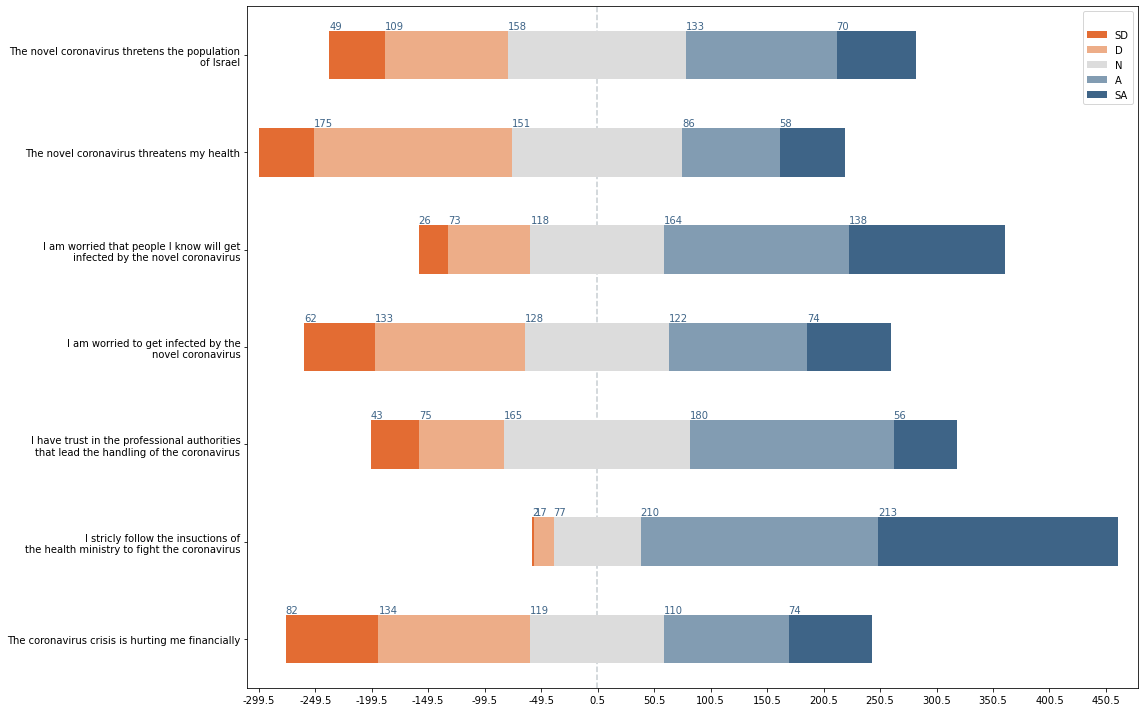

In [6]:
cols=['corona_financial_hurt', 'follow_instructions', 'trust_leaders', 'corona_worry_me', 'corona_worry_others', 
      'corona_threat_me', 'corona_threat_population'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
pivot_df = df1.transpose() 
pivot_df.columns = ['SD','D','N',
                     'A','SA']

pivot_df.rename(index={'corona_threat_population':'The novel coronavirus thretens the population\nof Israel'},inplace=True)
pivot_df.rename(index={'corona_threat_me':'The novel coronavirus threatens my health'},inplace=True)
pivot_df.rename(index={'corona_worry_others':'I am worried that people I know will get\ninfected by the novel coronavirus'},inplace=True)
pivot_df.rename(index={'corona_worry_me':'I am worried to get infected by the\nnovel coronavirus'},inplace=True)
pivot_df.rename(index={'trust_leaders':'I have trust in the professional authorities\nthat lead the handling of the coronavirus'},inplace=True)
pivot_df.rename(index={'follow_instructions':'I stricly follow the insuctions of\nthe health ministry to fight the coronavirus'},inplace=True)
pivot_df.rename(index={'corona_financial_hurt':'The coronavirus crisis is hurting me financially'},inplace=True)


create_stacked_bar(pivot_df, 1.5, savefile=True)

## Hamagen

We have asked our 520 participants about their views about The HaMagen app (The Shield) -- the official Israeli contact tracing app, developed by the Ministry of Health, and available for Android and iOS. These are some descriptive findings. 

About 31% of our participants have reported installing the app. This is higher than the official numbers of 1.58 million people who installed it in Israel (about 20% of the install base). However, our population is somewhat more educated than the average citizen -- and our results show a correlation between installation and education. 

People are not very happy with HaMagen. Only 28% will tend to recommend installing it to their friends and family (versus 43%). 27% think it will reduce their own chances of contracting the coronavirus and only 32% think it will reduce the spread of the virus in general (though only 28% have negative views).

Privacy concerns are prevelant. 59% feel that it collecs sensitive information (versus 19%) and 43% are worried for their privacy (versus 32% who do not have concerns). Further analysis shows that privacy concerns have a strong effect on installing the app and uninstalling it. 

          No  Yes  Removed
Install  308  166       45


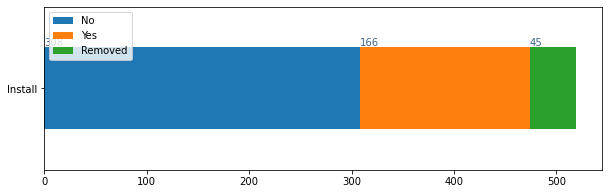

In [10]:
cols=['hamagen_install'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_install':'Install'},inplace=True)

print(pivot_df)

ax = pivot_df.plot.barh(stacked=True, figsize=(10,3))

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), horizontalalignment='left', verticalalignment='bottom', fontfamily='sans-serif', fontsize=10, color='#3e6487')

plt.savefig('hamagen_install.png', format='png', orientation='landscape')

          No  Yes  Removed
Install  308  166       45


<ipython-input-8-e856d631580c>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "landscape" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('hamagen_install.png', format='png', landscape='landscape', figsize=(12,8))
<ipython-input-8-e856d631580c>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('hamagen_install.png', format='png', landscape='landscape', figsize=(12,8))


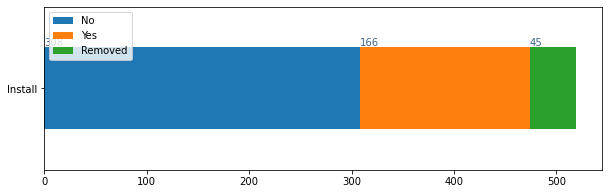

In [8]:
cols=['hamagen_install'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_install':'Install'},inplace=True)

print(pivot_df)

ax = pivot_df.plot.barh(stacked=True, figsize=(10,3))

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), horizontalalignment='left', verticalalignment='bottom', fontfamily='sans-serif', fontsize=10, color='#3e6487')



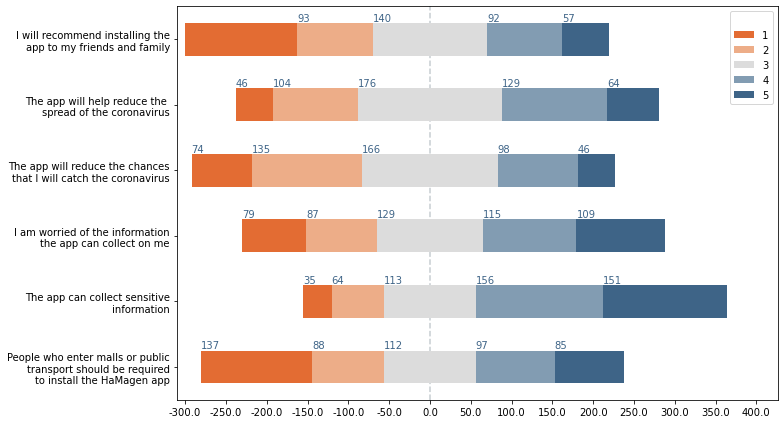

,1,2,3,4,5
People who enter malls or public\ntransport should be required\nto install the HaMagen app,137,88,112,97,85
The app can collect sensitive\ninformation,35,64,113,156,151
I am worried of the information\nthe app can collect on me,79,87,129,115,109
The app will reduce the chances\nthat I will catch the coronavirus,74,135,166,98,46
The app will help reduce the \nspread of the coronavirus,46,104,176,129,64
I will recommend installing the\napp to my friends and family,137,93,140,92,57


In [8]:
cols=['hamagen_public_areas', 'hamagen_can_collect_sensitive', 'hamagen_privacy_concern', 'hamagen_reduce_my_risk', 'hamagen_help_no_infect',
      'hamagen_recommend'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_recommend':'I will recommend installing the\napp to my friends and family'},inplace=True)
pivot_df.rename(index={'hamagen_help_no_infect':'The app will help reduce the \nspread of the coronavirus'},inplace=True)
pivot_df.rename(index={'hamagen_reduce_my_risk':'The app will reduce the chances\nthat I will catch the coronavirus'},inplace=True)
pivot_df.rename(index={'hamagen_privacy_concern':'I am worried of the information\nthe app can collect on me'},inplace=True)
pivot_df.rename(index={'hamagen_can_collect_sensitive':'The app can collect sensitive\ninformation'},inplace=True)
pivot_df.rename(index={'hamagen_public_areas':'People who enter malls or public\ntransport should be required\nto install the HaMagen app'},inplace=True)

##pivot_df.columns = ['Strongly Disagree','Disagree','Neutral','Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(11,6), savefile=True)
pivot_df

## Cellular Data Collection

- A large majority of Israelis think that the data in involontary cellular data collection will not be deleted
- More than half the population will understand if people would leave thier phones home to avoid being tracked
- People think that the cellular tracking will help prevent covid in someone more proportions than Hamagen
- Privacy concerns similar to Hamagen

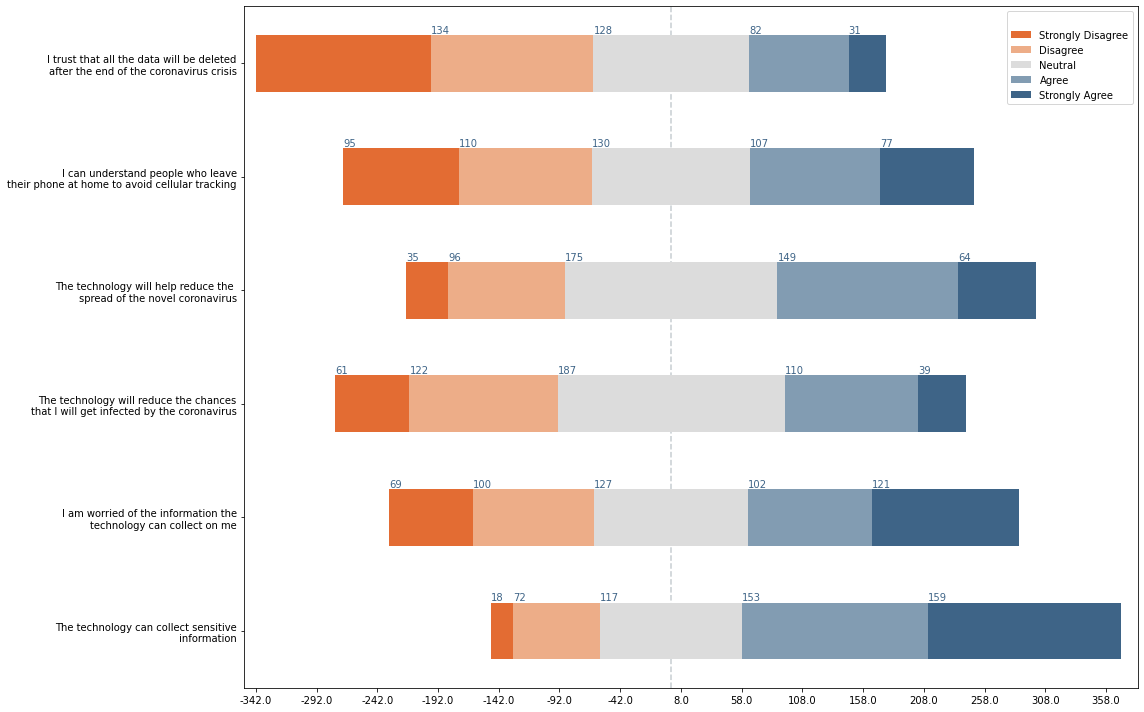

In [173]:
cols=['cellular_can_collect', 'cellular_privacy_concern', 
      'cellular_reduce_my_risk', 'cellular_help_prevent', 'cellular_accept_leave_phone_home', 'cellular_trust_delete',] 

small=sur[cols]
df1 = small.apply(pd.Series.value_counts)

likert_colors = ['firebrick','lightcoral','ivory','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 
pivot_df.rename(index={'cellular_trust_delete':'I trust that all the data will be deleted\nafter the end of the coronavirus crisis'},inplace=True)
pivot_df.rename(index={'cellular_accept_leave_phone_home':'I can understand people who leave\ntheir phone at home to avoid cellular tracking'},inplace=True)
pivot_df.rename(index={'cellular_help_prevent':'The technology will help reduce the \nspread of the novel coronavirus'},inplace=True)
pivot_df.rename(index={'cellular_reduce_my_risk':'The technology will reduce the chances\nthat I will get infected by the coronavirus'},inplace=True)
pivot_df.rename(index={'cellular_privacy_concern':'I am worried of the information the\ntechnology can collect on me'},inplace=True)
pivot_df.rename(index={'cellular_can_collect':'The technology can collect sensitive\ninformation'},inplace=True)


pivot_df.columns = ['Strongly Disagree','Disagree','Neutral',
                     'Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, savefile=True)

## Twitter publication

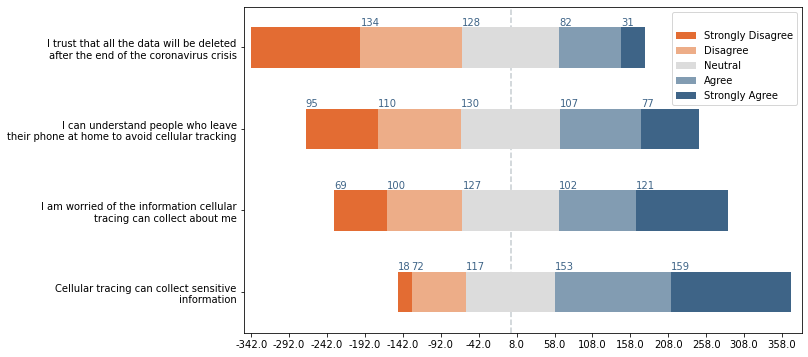

In [174]:
cols=['cellular_can_collect', 'cellular_privacy_concern', 
     'cellular_accept_leave_phone_home', 'cellular_trust_delete',] 

small=sur[cols]
df1 = small.apply(pd.Series.value_counts)

likert_colors = ['firebrick','lightcoral','ivory','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 
pivot_df.rename(index={'cellular_trust_delete':'I trust that all the data will be deleted\nafter the end of the coronavirus crisis'},inplace=True)
pivot_df.rename(index={'cellular_accept_leave_phone_home':'I can understand people who leave\ntheir phone at home to avoid cellular tracking'},inplace=True)
pivot_df.rename(index={'cellular_privacy_concern':'I am worried of the information cellular\ntracing can collect about me'},inplace=True)
pivot_df.rename(index={'cellular_can_collect':'Cellular tracing can collect sensitive\ninformation'},inplace=True)

pivot_df.columns = ['Strongly Disagree','Disagree','Neutral',
                     'Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(10,6))

# Visualizing binary variables

## Binary variables
- 32 work in healthcare 
- About 110 of the 520 are in special risk
- About 147 know a person that was tested positive for Covid-19

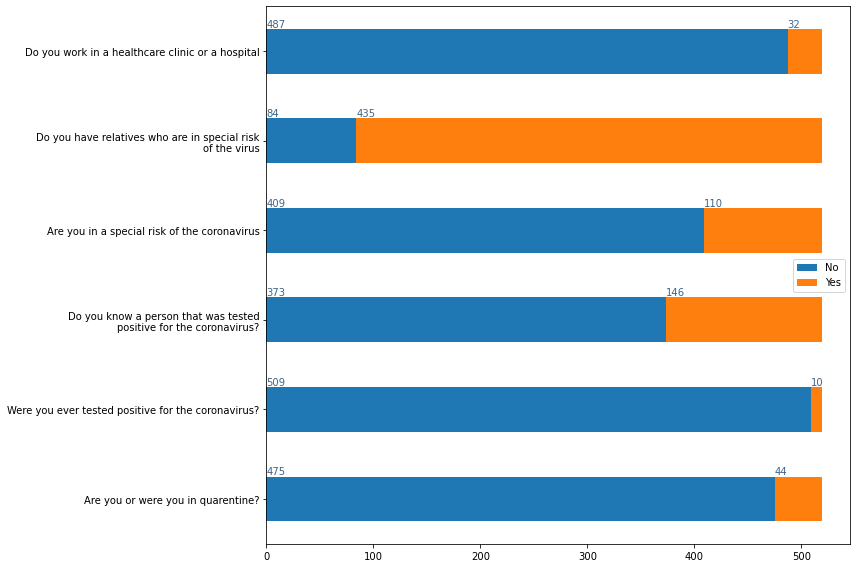

In [12]:
cols=['was_in_quarentine', 'corona_positive',  'corona_know_positive', 'special_risk', 'corona_family_risk', 
      'work_in_healthcare'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
pivot_df = df1.transpose() 

pivot_df.rename(index={'work_in_healthcare':'Do you work in a healthcare clinic or a hospital'},inplace=True)
pivot_df.rename(index={'special_risk':'Are you in a special risk of the coronavirus'},inplace=True)
pivot_df.rename(index={'corona_family_risk':'Do you have relatives who are in special risk\nof the virus'},inplace=True)
pivot_df.rename(index={'corona_know_positive':'Do you know a person that was tested\npositive for the coronavirus?'},inplace=True)
pivot_df.rename(index={'corona_positive':'Were you ever tested positive for the coronavirus?'},inplace=True)
pivot_df.rename(index={'was_in_quarentine':'Are you or were you in quarentine?'},inplace=True)


ax = pivot_df.plot.barh(stacked=True, figsize=(12,8))


for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), horizontalalignment='left', verticalalignment='bottom', fontfamily='sans-serif', fontsize=10, color='#3e6487')

plt.gcf().tight_layout()
plt.savefig('output.png', format='png')

In [13]:
pivot_df

,No,Yes
Are you or were you in quarentine?,475,44
Were you ever tested positive for the coronavirus?,509,10
Do you know a person that was tested\npositive for the coronavirus?,373,146
Are you in a special risk of the coronavirus,409,110
Do you have relatives who are in special risk\nof the virus,84,435
Do you work in a healthcare clinic or a hospital,487,32


### Gender

,female,male,other
gender,276,239,4


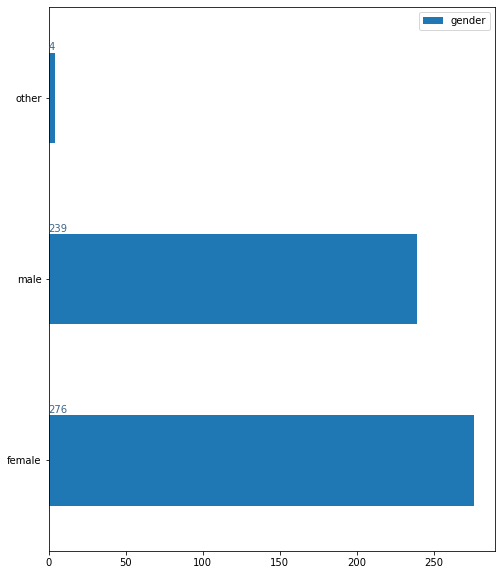

In [176]:
cols=['gender'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
pivot_df
ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

pivot_df

### Age

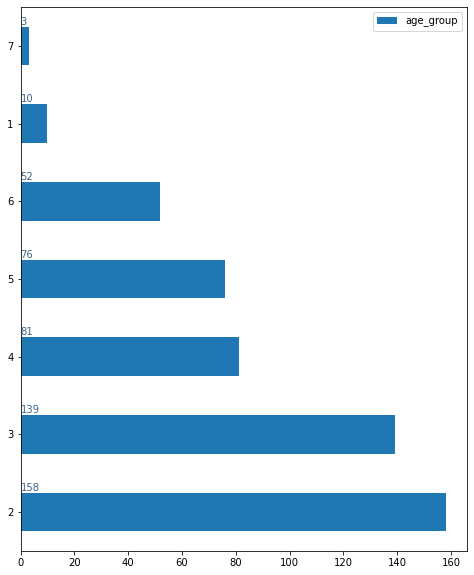

In [177]:
cols=['age_group'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
pivot_df
ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')


In [178]:
sur.age_group.value_counts()

2    158
3    139
4     81
5     76
6     52
1     10
7      3
Name: age_group, dtype: int64

### Religious Identification

          Jewish  Muslim  Druze  Christian
religion     426      55     22         16


,Jewish,Muslim,Druze,Christian
religion,426,55,22,16


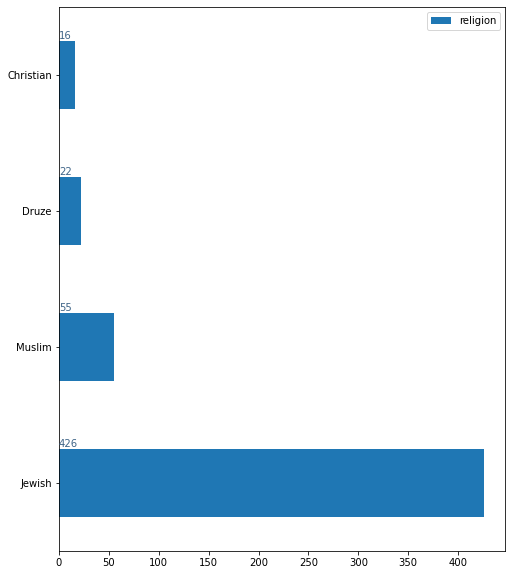

In [179]:
cols=['religion'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
print(pivot_df)

ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

pivot_df 

### Religious Level

                 Secular  Traditional  Other  Religious  Orthodox
religion_degree      190          139     93         57        40


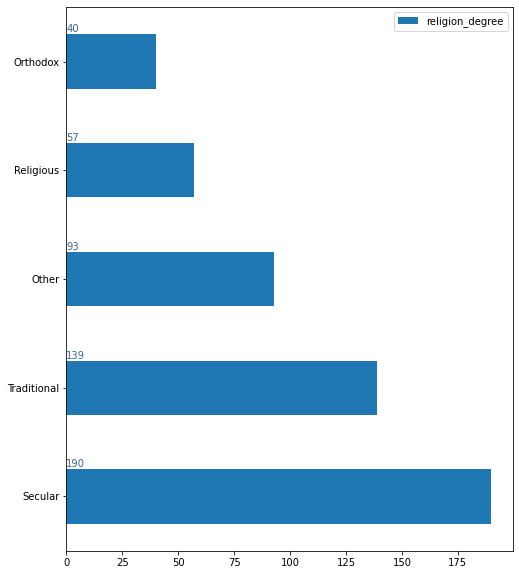

In [180]:
cols=['religion_degree'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
print(pivot_df)

ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')


### Education

,Bachelor,Non Academic,Highschool,Graduate,Elementary
education,184,139,112,81,3


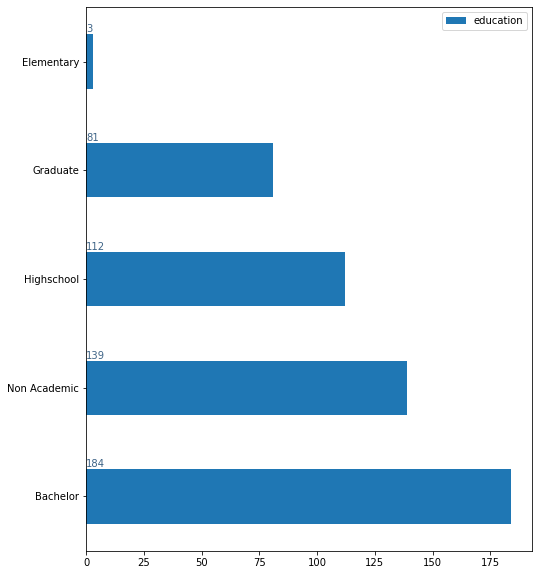

In [181]:
cols=['education'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

pivot_df

### Socio-Economic

,Below Average,Strongly Below Average,Average,Above Average,Strongly Above Average
socio_economy,165,141,138,61,14


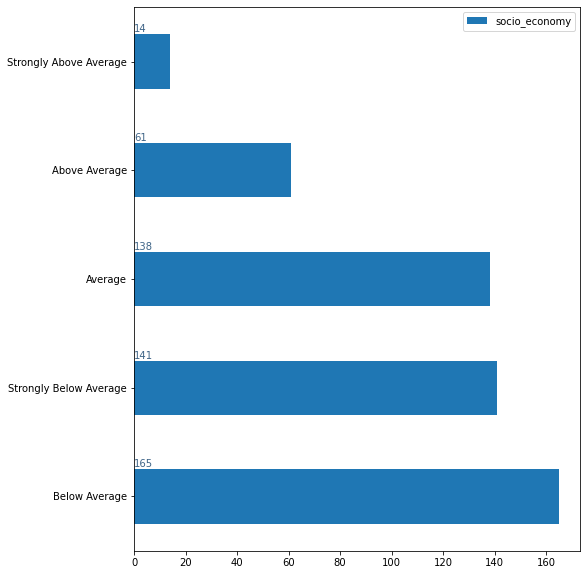

In [182]:
cols=['socio_economy'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 

ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

pivot_df

### Computer Literacy 

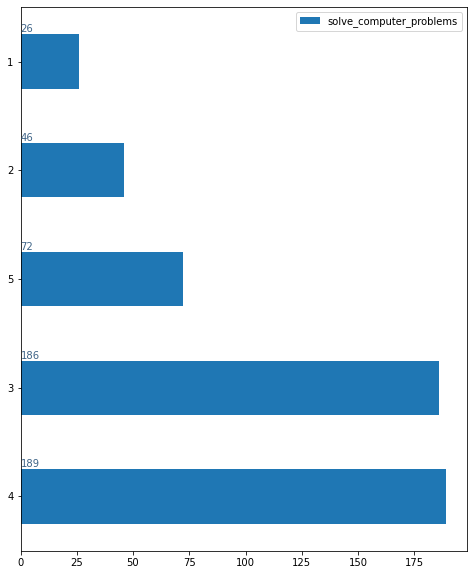

In [183]:
cols=['solve_computer_problems'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
pivot_df
ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')


<AxesSubplot:>

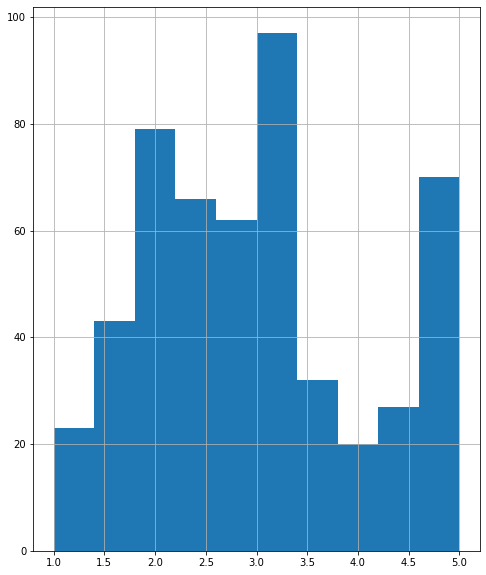

In [184]:
sur['tech'].hist()



# Analyzing Installations

Resources: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## Creating Dummy Variables

In [253]:
sur_no_removed = sur[sur['installed'] < 2].copy()

cat_vars=['gender','language', 'special_risk', 'work_in_healthcare', 'corona_family_risk', 'was_in_quarentine', 'corona_know_positive', 
          'corona_positive', 'age_group', 'education', 'religion', 'religion_degree', 'socio_economy']
for var in cat_vars:
    dummy = 'var'+'_'+var
    dummy = pd.get_dummies(sur[var], prefix=var)
    sur_no_removed = sur_no_removed.merge(dummy, left_index=True, right_index=True)

#sur_no_removed.info(verbose=True)



In [254]:
# Adding intercept 
sur_no_removed['intercept'] = 1.0

#Filtering uninstallations 
#sur_no_removed['hamagen_install_numbers'] = sur_no_removed['hamagen_install_numbers'].map({1 : 1, 0 : 0, 2 : 0})
sur_no_removed['hamagen_install_numbers'].value_counts()



0    308
1    166
Name: hamagen_install_numbers, dtype: int64

In [255]:
sur_no_removed.head()

,Time Started,Date Submitted,Status,age,corona_threat_population,corona_threat_me,corona_worry_me,corona_worry_others,trust_leaders,follow_instructions,was_in_quarentine,corona_financial_hurt,corona_positive,corona_know_positive,corona_family_risk,special_risk,work_in_healthcare,hamagen_install,hamagen_recommend,hamagen_help_no_infect,hamagen_reduce_my_risk,hamagen_privacy_concern,hamagen_can_collect_sensitive,hamagen_wrong_location,hamagen_errors,hamagen_battery,hamagen_public_areas,cellular_trust_delete,cellular_accept_leave_phone_home,cellular_help_prevent,cellular_reduce_my_risk,cellular_privacy_concern,cellular_can_collect,solve_computer_problems,know_pdf,know_spyware,know_wiki,know_cache,know_phishing,gender,education,socio_economy,religion,religion_degree,language,hamagen_install_numbers,installed,gender_ord,socio_economy_level,education_level,...,hamagen_limited_utility,cellular_attitude,hamagen_attitude,covid_concern,hamagen_utility,gender_female,gender_male,gender_other,language_arabic,language_hebrew,language_other,special_risk_No,special_risk_Yes,work_in_healthcare_No,work_in_healthcare_Yes,corona_family_risk_No,corona_family_risk_Yes,was_in_quarentine_No,was_in_quarentine_Yes,corona_know_positive_No,corona_know_positive_Yes,corona_positive_No,corona_positive_Yes,age_group_1,age_group_2,age_group_3,age_group_4,age_group_5,age_group_6,age_group_7,education_Bachelor,education_Elementary,education_Graduate,education_Highschool,education_Non Academic,religion_Christian,religion_Druze,religion_Jewish,religion_Muslim,religion_degree_Orthodox,religion_degree_Other,religion_degree_Religious,religion_degree_Secular,religion_degree_Traditional,socio_economy_Above Average,socio_economy_Average,socio_economy_Below Average,socio_economy_Strongly Above Average,socio_economy_Strongly Below Average,intercept
Response ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
379,05/05/2020 16:23,05/05/2020 16:26,Complete,21.0,3,2,4,4,3,5,No,4,No,No,Yes,No,No,No,2,3,2,4,3,NaN,NaN,NaN,2,3,4,3,2,4,3,5,5,4,5,5,5,male,Highschool,Below Average,Jewish,Secular,hebrew,0,0,1,1,2,...,2.5,2.666667,2.0,3.000000,2.5,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1.0
61,04/05/2020 19:23,04/05/2020 19:29,Complete,34.0,4,3,5,5,4,5,No,2,No,No,Yes,No,No,No,2,4,5,4,4,NaN,NaN,NaN,4,3,4,4,4,4,4,3,3,1,1,1,1,male,Highschool,Strongly Below Average,Muslim,Other,arabic,0,0,1,0,2,...,4.5,3.666667,3.0,4.000000,4.5,0,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1.0
280,05/05/2020 15:22,05/05/2020 15:24,Complete,21.0,2,3,4,2,3,3,No,3,No,No,No,No,No,Yes,3,3,3,3,3,3.0,3.0,3.0,3,3,3,3,3,3,3,3,3,3,3,3,3,male,Bachelor,Below Average,Druze,Other,arabic,1,1,1,1,4,...,3.0,3.000000,3.0,3.000000,3.0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1.0
288,05/05/2020 15:24,05/05/2020 15:33,Complete,65.0,2,3,1,1,4,5,No,3,No,No,No,No,No,No,2,4,4,3,4,NaN,NaN,NaN,1,3,3,4,4,1,4,3,4,1,1,3,1,female,Highschool,Average,Jewish,Traditional,hebrew,0,0,0,3,2,...,4.0,3.666667,1.5,2.000000,4.0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1.0
96,04/05/2020 23:27,04/05/2020 23:30,Complete,37.0,2,2,3,4,2,3,No,3,No,No,Yes,No,No,No,1,3,2,5,5,NaN,NaN,NaN,2,1,4,3,3,5,5,3,4,3,2,1,4,male,Bachelor,Average,Muslim,Other,arabic,0,0,1,3,4,...,2.5,2.333333,1.5,2.333333,2.5,0,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1.0


In [256]:
cols=['intercept', 'corona_family_risk_No', 'hamagen_attitude', 'covid_concern',  'trust_leaders', 'follow_instructions',
      'hamagen_utility', 'hamagen_privacy', 'cellular_utility', 'tech', 'special_risk_Yes', 'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
      'age_group_5','age_group_6','age_group_7','gender_female', 
      'education_Graduate', 'religion_Muslim', 'religion_Jewish',
      'religion_degree_Orthodox', 'religion_degree_Religious', 'corona_know_positive_Yes', 'special_risk_No', 
      'socio_economy_Above Average', 'socio_economy_Average', 'socio_economy_Strongly Below Average', 'socio_economy_Below Average'] 



X=sur_no_removed[cols]
y=sur_no_removed['hamagen_install_numbers']

## Feature Selection

Taken from: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

### Embedded Method with Lasso regularization

Best alpha using built-in LassoCV: 0.017432
Best score using built-in LassoCV: 0.290681
Lasso picked 5 variables and eliminated the other 25 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

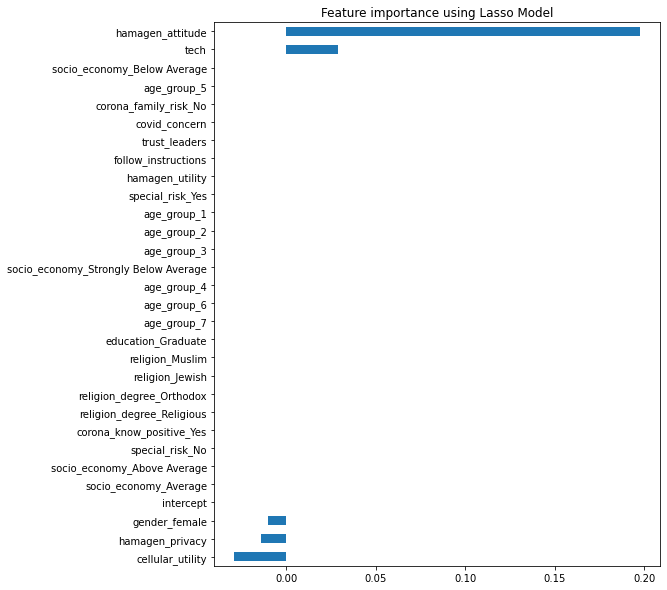

In [257]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Recursive Feature Elimination


In [258]:
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression()
number_of_features = 13
#Initializing RFE model
rfe = RFE(model, number_of_features)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

[False False  True False False False False  True  True False False  True
  True False False False False  True  True  True  True  True  True  True
  True False False False False False]
[16 17  1 10 13  5 11  1  1  2 18  1  1  6  8  7  3  1  1  1  1  1  1  1
  1 14 12  4 15  9]
Index(['hamagen_attitude', 'hamagen_privacy', 'cellular_utility',
       'age_group_1', 'age_group_2', 'age_group_7', 'gender_female',
       'education_Graduate', 'religion_Muslim', 'religion_Jewish',
       'religion_degree_Orthodox', 'religion_degree_Religious',
       'corona_know_positive_Yes'],
      dtype='object')


In [259]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))


Optimum number of features: 1
Score with 1 features: 0.790210


## Analyzing demographics and HaMagen installations

### Installation by gender
- The proportion of installations for men is higher

In [72]:
pd.crosstab(sur.gender,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
gender,,,
female,0.644928,0.079710,0.275362
male,0.531381,0.096234,0.372385
other,0.750000,0.000000,0.250000


### Installation by age group
- older adults install in about 80% more than younger adults

In [73]:
pd.crosstab(sur.age_group,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
age_group,,,
1,0.600000,0.100000,0.300000
2,0.639241,0.094937,0.265823
3,0.611511,0.079137,0.309353
4,0.555556,0.086420,0.358025
5,0.592105,0.078947,0.328947
6,0.500000,0.096154,0.403846
7,0.000000,0.000000,1.000000


### Installation by Religion
- Seems that proportions of installations are similar between religions

In [74]:
pd.crosstab(sur.religion,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
religion,,,
Christian,0.562500,0.062500,0.375000
Druze,0.590909,0.136364,0.272727
Jewish,0.584507,0.093897,0.321596
Muslim,0.672727,0.018182,0.309091


### Differences in installation according to religion degree
- Secular and traditional particpnats installed it more

In [75]:
pd.crosstab(sur.religion_degree,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
religion_degree,,,
Orthodox,0.650000,0.075000,0.275000
Other,0.634409,0.053763,0.311828
Religious,0.666667,0.070175,0.263158
Secular,0.557895,0.105263,0.336842
Traditional,0.568345,0.093525,0.338129


In [76]:
sur.religion_degree.value_counts()

Secular        190
Traditional    139
Other           93
Religious       57
Orthodox        40
Name: religion_degree, dtype: int64

### Differences of installation according to education
- Graduates install the app about 30-40% more than others
- Number of elemntary is very small - 3

In [77]:
pd.crosstab(sur.education,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
education,,,
Bachelor,0.586957,0.076087,0.336957
Elementary,0.666667,0.000000,0.333333
Graduate,0.493827,0.086420,0.419753
Highschool,0.651786,0.053571,0.294643
Non Academic,0.611511,0.129496,0.258993


In [78]:
pd.crosstab(sur.education,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
education,,,
Bachelor,0.586957,0.076087,0.336957
Elementary,0.666667,0.000000,0.333333
Graduate,0.493827,0.086420,0.419753
Highschool,0.651786,0.053571,0.294643
Non Academic,0.611511,0.129496,0.258993


In [79]:
sur.education.value_counts()

Bachelor        184
Non Academic    139
Highschool      112
Graduate         81
Elementary        3
Name: education, dtype: int64

# Comparing HaMagen and Cellular Tracking

Conclusions:
- We don't see significant differences in the approach 

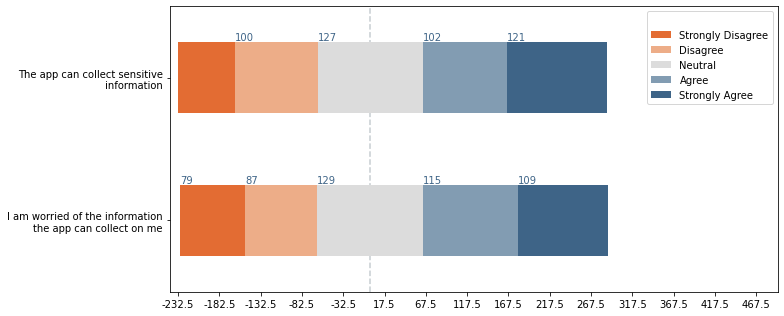

,Strongly Disagree,Disagree,Neutral,Agree,Strongly Agree
I am worried of the information\nthe app can collect on me,79,87,129,115,109
The app can collect sensitive\ninformation,69,100,127,102,121


In [82]:
cols=['hamagen_privacy_concern', 'cellular_privacy_concern'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_privacy_concern':'I am worried of the information\nthe app can collect on me'},inplace=True)
pivot_df.rename(index={'cellular_privacy_concern':'The app can collect sensitive\ninformation'},inplace=True)

pivot_df.columns = ['Strongly Disagree','Disagree','Neutral','Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(11,4.5), savefile=True)
pivot_df


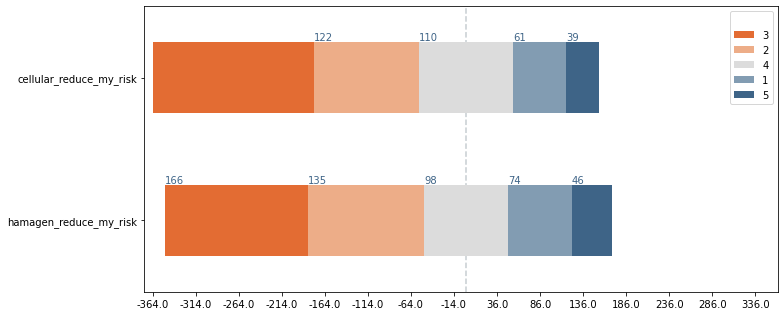

,3,2,4,1,5
hamagen_reduce_my_risk,166,135,98,74,46
cellular_reduce_my_risk,187,122,110,61,39


In [83]:
cols=['hamagen_reduce_my_risk', 'cellular_reduce_my_risk'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_reduce_my_risk':'hamagen_reduce_my_risk'},inplace=True)
pivot_df.rename(index={'cellular_reduce_my_risk':'cellular_reduce_my_risk'},inplace=True)

#pivot_df.columns = ['Strongly Disagree','Disagree','Neutral','Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(11,4.5), savefile=True)
pivot_df

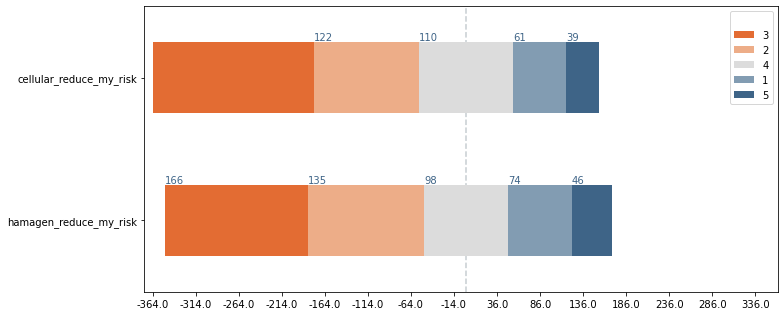

,3,2,4,1,5
hamagen_reduce_my_risk,166,135,98,74,46
cellular_reduce_my_risk,187,122,110,61,39


In [84]:
cols=['hamagen_reduce_my_risk', 'cellular_reduce_my_risk'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_reduce_my_risk':'hamagen_reduce_my_risk'},inplace=True)
pivot_df.rename(index={'cellular_reduce_my_risk':'cellular_reduce_my_risk'},inplace=True)

#pivot_df.columns = ['Strongly Disagree','Disagree','Neutral','Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(11,4.5), savefile=True)
pivot_df

<AxesSubplot:xlabel='hamagen_install'>

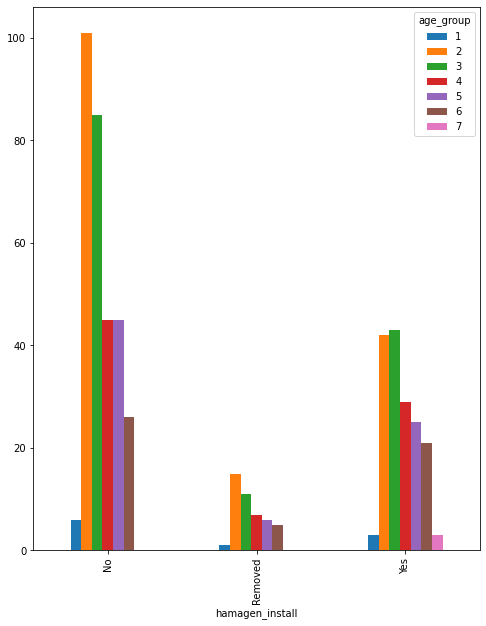

In [85]:
pd.crosstab(sur.hamagen_install,sur.age_group).plot(kind='bar')


In [86]:
sur.cellular_accept_leave_phone_home.corr(sur.cellular_trust_delete)

-0.216254002775652

Ttest_relResult(statistic=-1.8204559911317484, pvalue=0.06926646431096624)

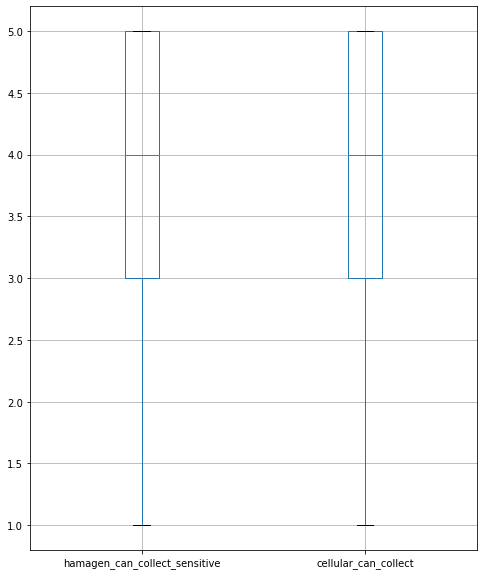

In [87]:
sur.boxplot(column=['hamagen_can_collect_sensitive', 'cellular_can_collect'])
stats.ttest_rel(sur['hamagen_can_collect_sensitive'], sur['cellular_can_collect'])
#stats.wilcoxon(sur['hamagen_help_prevent'], sur['cellular_help_prevent'])


Ttest_relResult(statistic=-0.7536231544523575, pvalue=0.4514179413395366)

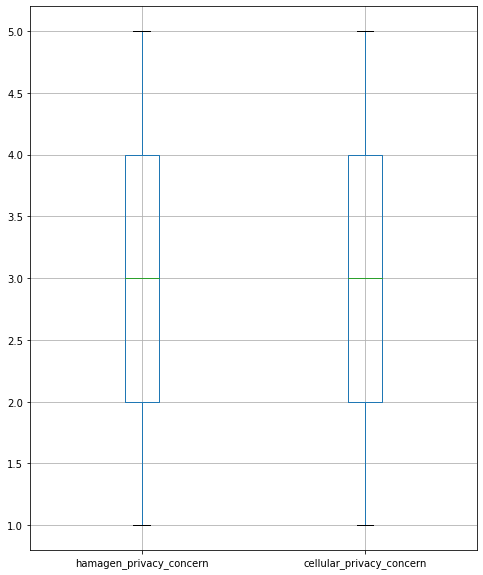

In [88]:
sur.boxplot(column=['hamagen_privacy_concern', 'cellular_privacy_concern'])
stats.ttest_rel(sur['hamagen_privacy_concern'], sur['cellular_privacy_concern'])
#stats.wilcoxon(sur['hamagen_help_prevent'], sur['cellular_help_prevent'])

Ttest_relResult(statistic=-1.7654944583904413, pvalue=0.07806979910727373)

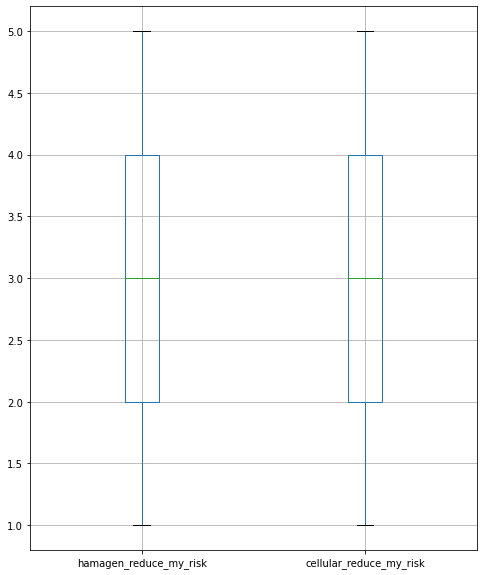

In [89]:
sur.boxplot(column=['hamagen_reduce_my_risk', 'cellular_reduce_my_risk'])
stats.ttest_rel(sur['hamagen_reduce_my_risk'], sur['cellular_reduce_my_risk'])
#stats.wilcoxon(sur['hamagen_help_prevent'], sur['cellular_help_prevent'])

WilcoxonResult(statistic=18579.5, pvalue=0.01884950499683455)

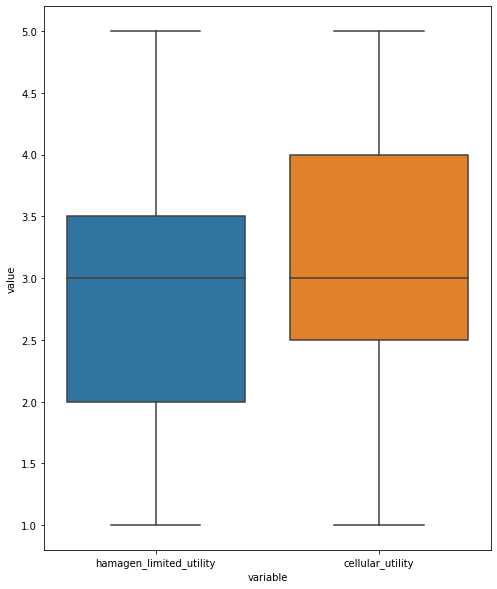

In [90]:
df = pd.DataFrame(data = sur, columns = ['hamagen_limited_utility','cellular_utility'])

sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.savefig('hamagen_cellular_utility.png', format='png', landscape='landscape', figsize=(6,6))
stats.ttest_rel(sur['hamagen_limited_utility'], sur['cellular_utility'])
stats.wilcoxon(sur['hamagen_limited_utility'], sur['cellular_utility'])

<AxesSubplot:xlabel='variable', ylabel='value'>

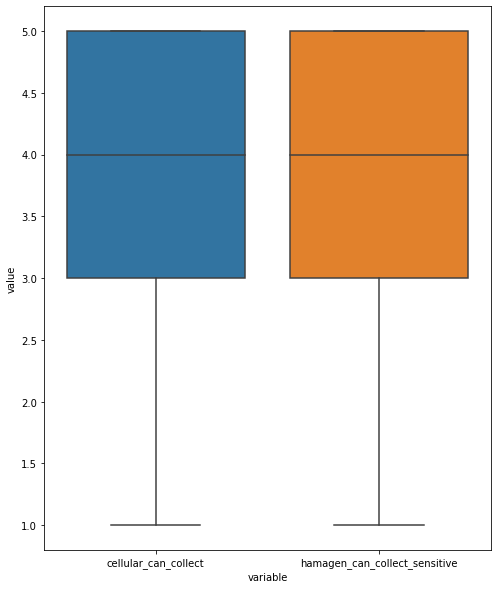

In [91]:
df = pd.DataFrame(data = sur, columns = ['cellular_can_collect','hamagen_can_collect_sensitive'])

sns.boxplot(x="variable", y="value", data=pd.melt(df))
#plt.savefig('hamagen_cellular_sensitive.png', format='png')
#stats.wilcoxon(sur['cellular_can_collect'], sur['hamagen_can_collect_sensitive'])

# Factor Analysis

from: https://www.datacamp.com/community/tutorials/introduction-factor-analysis

API: https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html


In [1]:
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)    

model_dict = {"hamagen_privacy": ["hamagen_privacy_concern", "hamagen_can_collect_sensitive"], 
              "covid_concern": ["corona_threat_population", "corona_threat_me", "corona_worry_me"]}

#model_dict = {"F1": ["V1", "V2", "V3", "V4"], "F2": ["V5", "V6", "V7", "V8"]}

model_spec = ModelSpecificationParser.parse_model_specification_from_dict(sur, model_dict)

cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False) 

cfa.fit(sur.values) 

cfa.loadings_ 

NameError: name 'sur' is not defined

In [333]:
cols=['corona_threat_population', 'corona_threat_me', 'corona_worry_me', 'corona_worry_others', 
     'hamagen_privacy_concern', 'hamagen_can_collect_sensitive', 
      'cellular_help_prevent', 'cellular_reduce_my_risk', 'cellular_trust_delete',
      'hamagen_recommend', 'hamagen_public_areas',
     'hamagen_help_no_infect', 'hamagen_reduce_my_risk'] 
X=sur[cols]



#sur['hamagen_privacy'] = (sur.hamagen_privacy_concern + sur.hamagen_can_collect_sensitive) / 2
#sur['cellular_utility'] = (sur.cellular_help_prevent + sur.cellular_reduce_my_risk) / 2
#sur['cellular_privacy'] = (sur.cellular_privacy_concern + sur.cellular_can_collect) / 2
#sur['hamagen_limited_utility'] = (sur.hamagen_help_no_infect + sur.hamagen_reduce_my_risk) / 2
#sur['cellular_attitude'] = (sur.cellular_help_prevent + sur.cellular_reduce_my_risk + sur.cellular_trust_delete) / 3 
#sur['hamagen_attitude'] = (sur.hamagen_recommend + sur.hamagen_public_areas) / 2
#sur['covid_concern'] = (sur.corona_threat_population + sur.corona_threat_me + sur.corona_worry_me) / 3

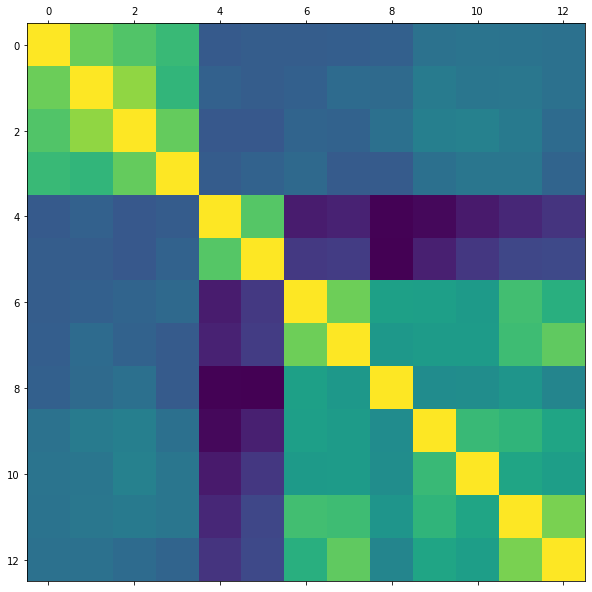

,corona_threat_population,corona_threat_me,corona_worry_me,corona_worry_others,hamagen_privacy_concern,hamagen_can_collect_sensitive,cellular_help_prevent,cellular_reduce_my_risk,cellular_trust_delete,hamagen_recommend,hamagen_public_areas,hamagen_help_no_infect,hamagen_reduce_my_risk
corona_threat_population,1.000000,0.698606,0.634074,0.568148,0.035292,0.054131,0.052709,0.060200,0.068248,0.161028,0.171095,0.167657,0.156239
corona_threat_me,0.698606,1.000000,0.778991,0.543251,0.073919,0.054667,0.068236,0.124738,0.119095,0.213523,0.183048,0.190840,0.157435
corona_worry_me,0.634074,0.778991,1.000000,0.684017,0.025167,0.026775,0.090040,0.078356,0.151987,0.236845,0.248726,0.207714,0.123807
corona_worry_others,0.568148,0.543251,0.684017,1.000000,0.048766,0.081176,0.113388,0.043736,0.041880,0.152218,0.185494,0.184288,0.090756
hamagen_privacy_concern,0.035292,0.073919,0.025167,0.048766,1.000000,0.645640,-0.242754,-0.217172,-0.336809,-0.315366,-0.246969,-0.191394,-0.138788
hamagen_can_collect_sensitive,0.054131,0.054667,0.026775,0.081176,0.645640,1.000000,-0.122932,-0.104328,-0.343339,-0.227465,-0.124559,-0.059088,-0.046605
cellular_help_prevent,0.052709,0.068236,0.090040,0.113388,-0.242754,-0.122932,1.000000,0.704603,0.422108,0.416630,0.388150,0.594232,0.503183
cellular_reduce_my_risk,0.060200,0.124738,0.078356,0.043736,-0.217172,-0.104328,0.704603,1.000000,0.373775,0.395445,0.395816,0.584867,0.669432
cellular_trust_delete,0.068248,0.119095,0.151987,0.041880,-0.336809,-0.343339,0.422108,0.373775,1.000000,0.311923,0.314619,0.356353,0.269800
hamagen_recommend,0.161028,0.213523,0.236845,0.152218,-0.315366,-0.227465,0.416630,0.395445,0.311923,1.000000,0.565458,0.537873,0.447148


In [334]:

plt.matshow(X.corr())
plt.show()
X.corr()

In [299]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(X)
chi_square_value, p_value


(397.2146070175929, 1.1151710355307094e-88)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [300]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(X)
kmo_model


0.4990356807424434

In [302]:
fa = FactorAnalyzer(rotation="varimax", n_factors=1)
fa.fit(X)
print(fa.loadings_)

[[0.85514334]
 [0.85514334]]


In [146]:
fa.get_communalities()

array([0.5951658 , 0.72853722, 0.81219003, 0.51875477, 0.62207634,
       0.99868097, 0.79950742, 0.99829716, 0.48169963, 0.96640513,
       0.99714776, 0.62503794])

In [147]:
ev, v = fa.get_eigenvalues()
ev

array([4.28024988, 2.70244978, 1.50373868, 0.9659477 , 0.57165441,
       0.48800675, 0.38175228, 0.33520894, 0.32255023, 0.18663245,
       0.16982006, 0.09198884])

In [148]:
fa.get_factor_variance()

(array([2.67634187, 2.06362722, 1.80573773, 1.46424697, 1.13354638]),
 array([0.22302849, 0.17196894, 0.15047814, 0.12202058, 0.0944622 ]),
 array([0.22302849, 0.39499742, 0.54547557, 0.66749615, 0.76195835]))